In [1]:
import pandas as pd
import numpy as np
import math

import time
import datetime



from wordcloud import WordCloud, ImageColorGenerator
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import seaborn as sns; sns.set(style='white')
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [2]:
def preprocess_to_squad(df: pd.DataFrame):
    contexts = []
    answers = []
    toxic_words = []
    number_of_toxic_words = []

    for i in range(len(df)):
        
        text_str = df['spans'][i]

        splitted_str = text_str[1:-1].split(", ")

        if len(splitted_str) == 1:
            contexts.append(text_str)
            number_of_toxic_words.append(0)
            continue


        splitted_str = list(map(int, splitted_str))
        
        context = df['text'][i]

        gaps = [[s, e] for s, e in zip(splitted_str, splitted_str[1:]) if s + 1 < e]
        edges = iter(splitted_str[:1] + sum(gaps, []) + splitted_str[-1:])
        unformatted_answers = list(zip(edges, edges))

        for tokens in unformatted_answers:
            start_token, end_token = tokens[0], tokens[1]
            
            answer = {}
            answer["start_ans"] = start_token
            answer["end_ans"] = end_token + 1
            answer['ans'] = context[start_token:end_token + 1]
            toxic_words.append(context[start_token:end_token + 1])

            answers.append(answer)
            contexts.append(context)
        
        
        number_of_toxic_words.append(len(unformatted_answers))
                      

    return contexts, answers, toxic_words, number_of_toxic_words

def plot_hist(df, postfix):
    ax = df.text.apply(lambda x: len(x.split())).hist(figsize = (12, 6));
    ax.set_ylabel("Количество текстов");
    ax.set_xlabel(f"Количество слов в текстах в {postfix} выборке");
    ax.set_title(f"Распределение количества слов в текстах в {postfix} выборке")
    
    fig = ax.get_figure()
    fig.savefig(f"Распределение на {postfix}.png")
    return ax

def plot_toxic_hist(num_toxic):
    labels, counts = np.unique(num_toxic, return_counts=True)
    plt.figure(figsize=(15,6))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    for label, count in zip(labels, counts):
        plt.text(x=label - 0.2 , y = count + 100 , s = count, fontdict=dict(fontsize=10))
    plt.tight_layout()

    plt.show()
    

def plot_word_cloud(corpus, name, toxic = ''):           
    plt.figure(figsize=(12,6))
    word_cloud = WordCloud(background_color='white', max_font_size = 80).generate(" ".join(corpus))
    plt.imshow(word_cloud)
    plt.title(f"Облако {toxic} слов на корпусе из {name} выборки")
    plt.savefig(f"Облако {toxic} слов на корпусе из {name} выборки.png")
    plt.axis('off')
    plt.show()
    
def corpus_from_text(text):
    corpus = []
    for sentence in text:
        for word in sentence:
            #print(word)
            corpus.append(word)
            
    return corpus

def corpus_from_toxic(toxic_text):
    corpus = []

    for sentence in toxic_text:
        if isinstance(sentence.split(), list):
            for word in sentence.split():
                corpus.append(word)
                
    return corpus

# Analysis

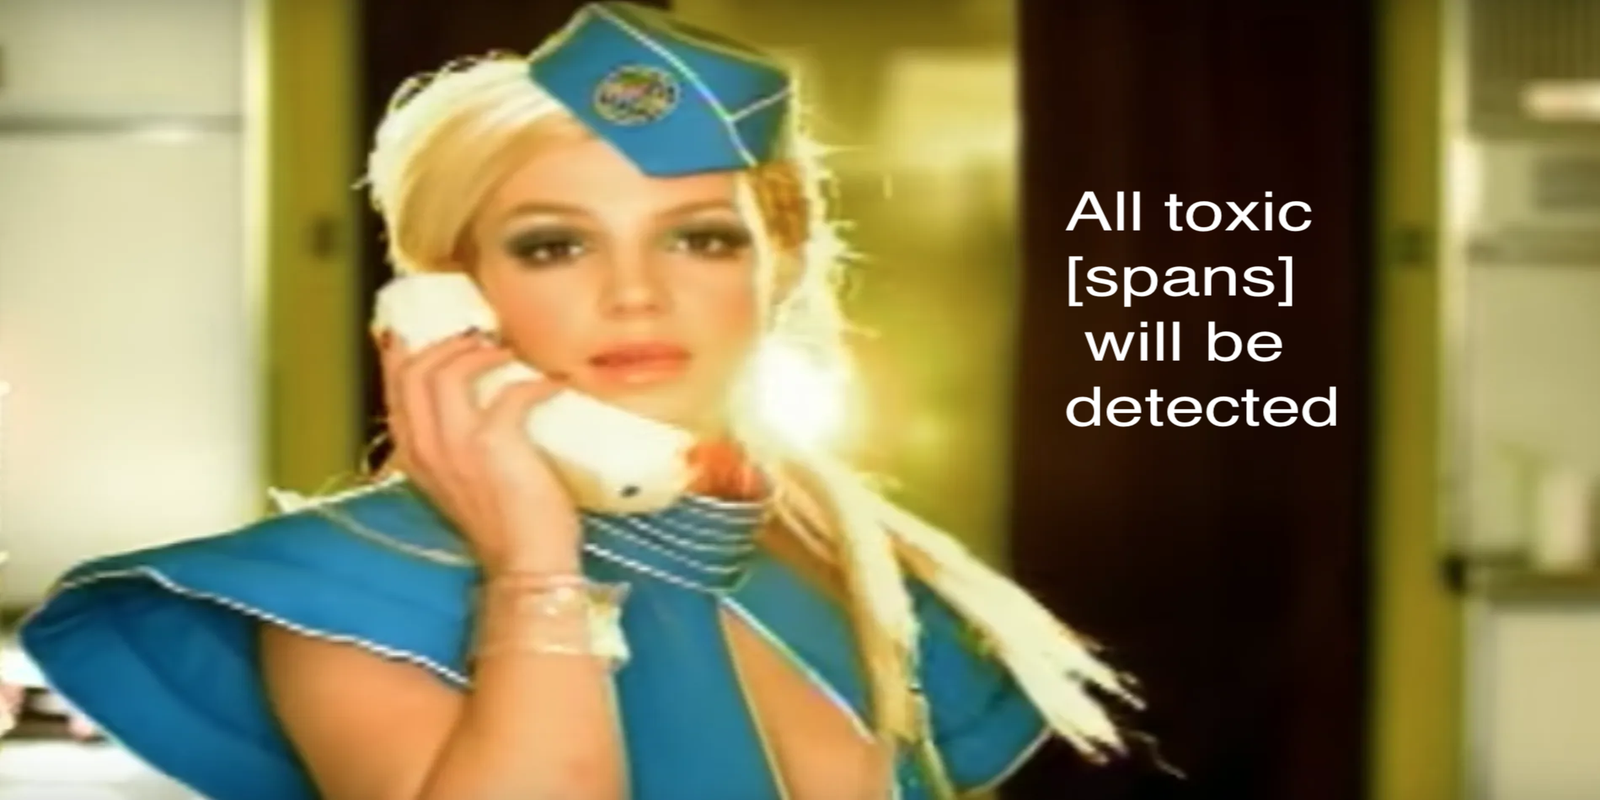

In [3]:
img_size = 800
img = Image.open("../input/toxic-britney/meme.png")
img = img.resize((img_size*2, img_size), Image.ANTIALIAS)
img

# # надеюсь, что это смешно

In [4]:
url_test = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_test.csv"
url_train = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_train.csv"
url_trial = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_trial.csv"

train_df = pd.read_csv(url_train, error_bad_lines=False)
test_df = pd.read_csv(url_test, error_bad_lines=False)
trial_df = pd.read_csv(url_trial, error_bad_lines=False)

In [5]:
train_contexts, train_answers, train_toxic_words, num_train_toxic = preprocess_to_squad(train_df)
val_contexts, val_answers, val_toxic_words, num_val_toxic = preprocess_to_squad(trial_df)
test_contexts, test_answers, test_toxic_words, num_test_toxic = preprocess_to_squad(test_df)

In [6]:
train_df_corpus = corpus_from_text(train_df.text.apply(lambda x: str(x).split()))
val_df_corpus = corpus_from_text(trial_df.text.apply(lambda x: str(x).split()))
test_df_corpus = corpus_from_text(test_df.text.apply(lambda x: str(x).split()))

### Анализ 

#### Обучающая выборка

In [7]:
title = 'обучающей'
toxic = 'токсичных'

In [8]:
print(f'Количество текстов в {title} выборке: ', len(train_df))

Количество текстов в обучающей выборке:  7939


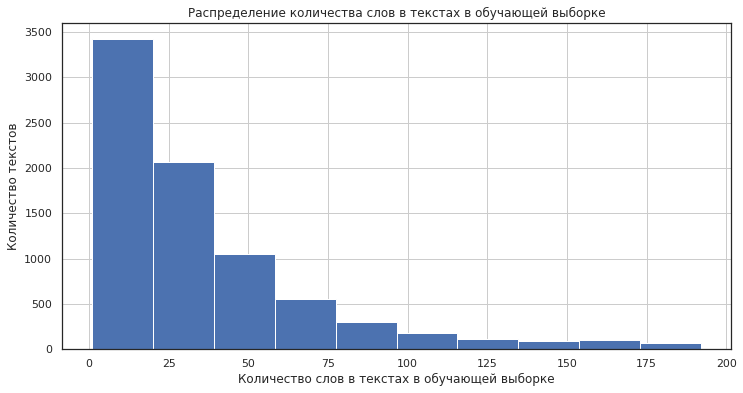

In [9]:
plot_hist(train_df, title);

In [10]:
print('Максимальное количество слов в обучающей выборке: ',  max(train_df.text.apply(lambda x: len(x.split()))))

Максимальное количество слов в обучающей выборке:  192


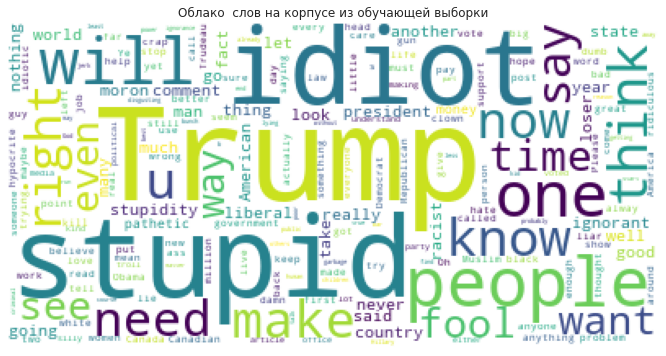

In [11]:
plot_word_cloud(train_df_corpus, title)

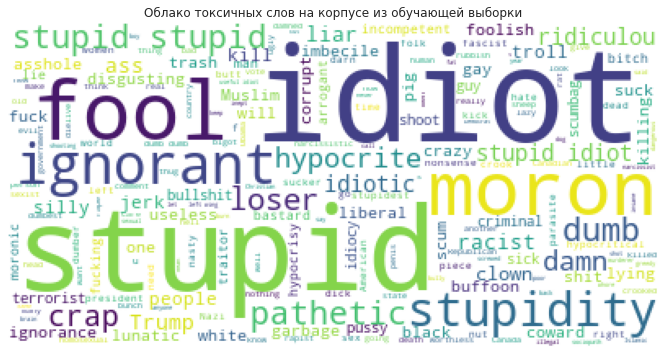

In [12]:
plot_word_cloud(train_toxic_words, title, toxic)

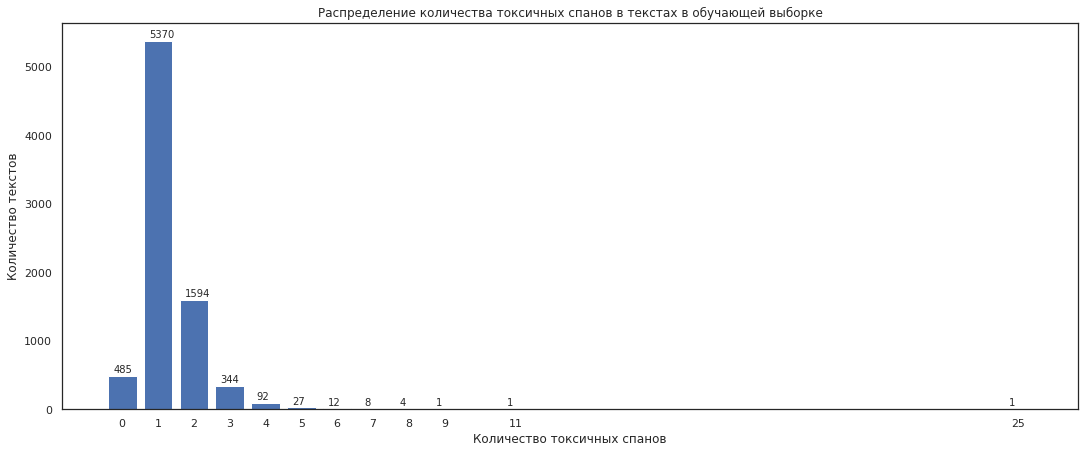

In [13]:
labels, counts = np.unique(num_train_toxic, return_counts=True)
plt.figure(figsize=(15,6))
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
for label, count in zip(labels, counts):
    plt.text(x=label - 0.25, y = count + 50 , s = count, fontdict=dict(fontsize=10))
plt.tight_layout()
plt.xlabel('Количество токсичных спанов')
plt.ylabel('Количество текстов')
plt.title('Распределение количества токсичных спанов в текстах в обучающей выборке')
plt.savefig('Распределение токсичных спанов в обучающей выборке.png')
plt.show()

#### Тестовая выборка

In [14]:
title = 'тестовой'

In [15]:
print(f'Количество текстов в {title} выборке: ', len(test_df))

Количество текстов в тестовой выборке:  2000


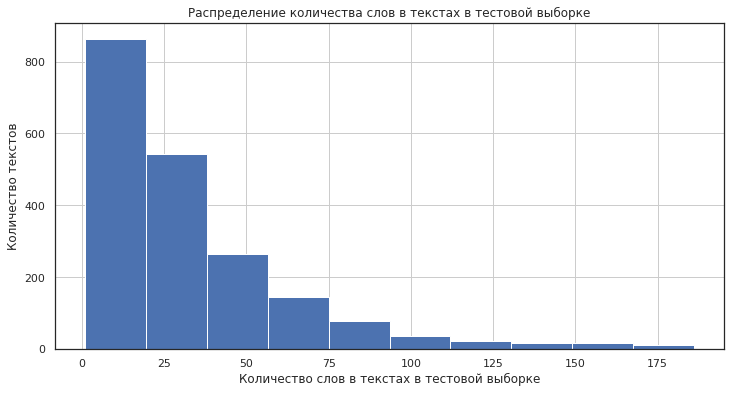

In [16]:
plot_hist(test_df, title);

In [17]:
print('Максимальное количество слов в тестовой выборке: ',  max(test_df.text.apply(lambda x: len(x.split()))))

Максимальное количество слов в тестовой выборке:  186


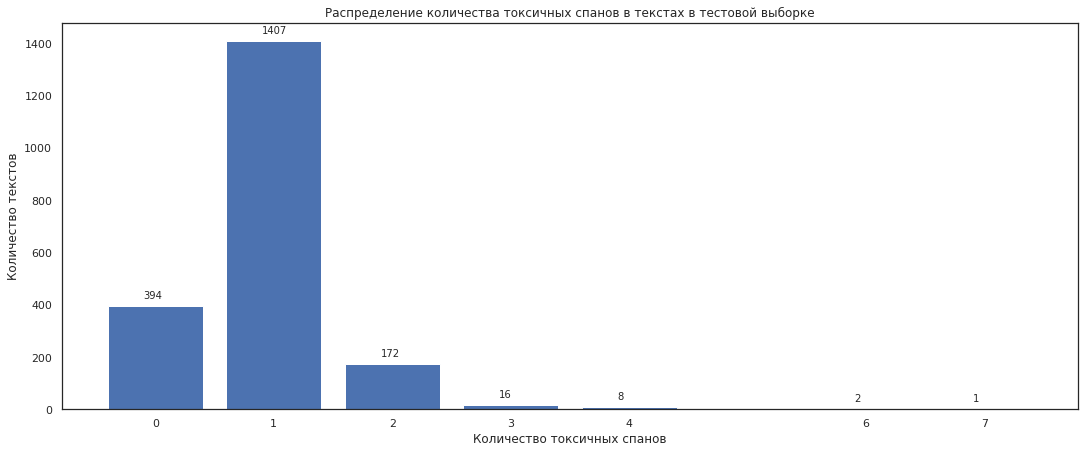

In [18]:
labels, counts = np.unique(num_test_toxic, return_counts=True)
plt.figure(figsize=(15,6))
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
for label, count in zip(labels, counts):
    plt.text(x=label - 0.1, y = count + 30 , s = count, fontdict=dict(fontsize=10))
plt.tight_layout()
plt.xlabel('Количество токсичных спанов')
plt.ylabel('Количество текстов')
plt.title('Распределение количества токсичных спанов в текстах в тестовой выборке')
plt.savefig('Распределение токсичных спанов в тестовой выборке.png')
plt.show()

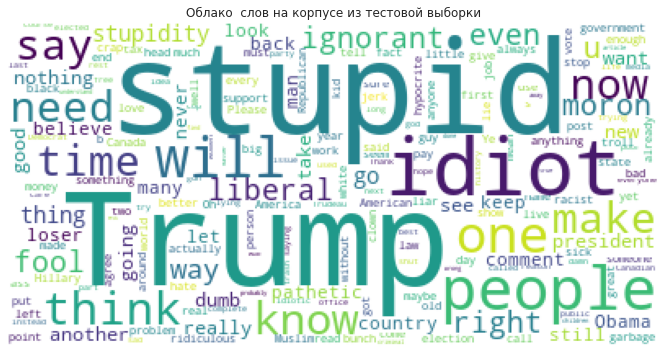

In [19]:
plot_word_cloud(test_df_corpus, title)

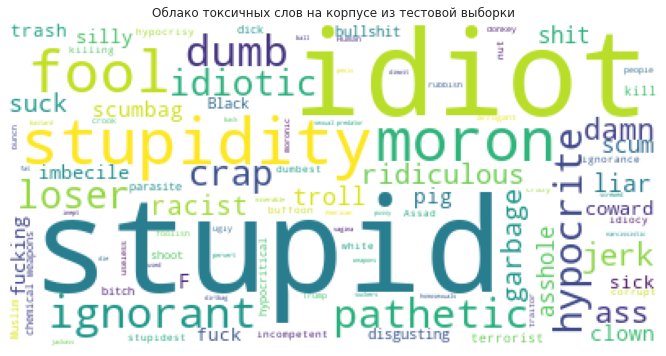

In [20]:
plot_word_cloud(test_toxic_words, title, toxic)

#### Валидационная выборка

In [21]:
title = 'валидационной'

In [22]:
print(f'Количество текстов в {title} выборке: ', len(trial_df))
print(f'Максимальное количество слов в {title} выборке: ',  max(trial_df.text.apply(lambda x: len(x.split()))))

Количество текстов в валидационной выборке:  690
Максимальное количество слов в валидационной выборке:  182


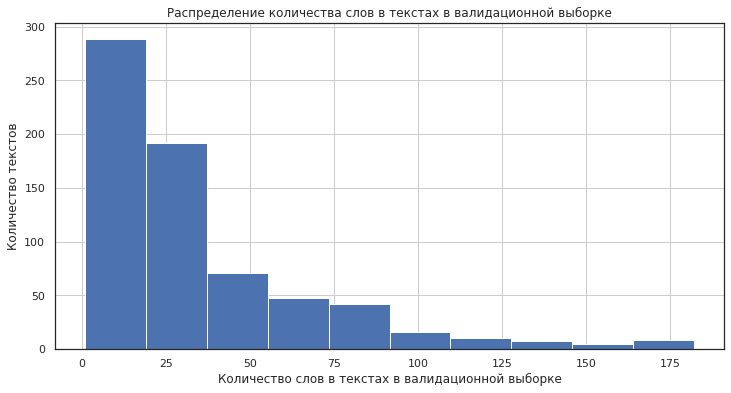

In [23]:
plot_hist(trial_df, title);

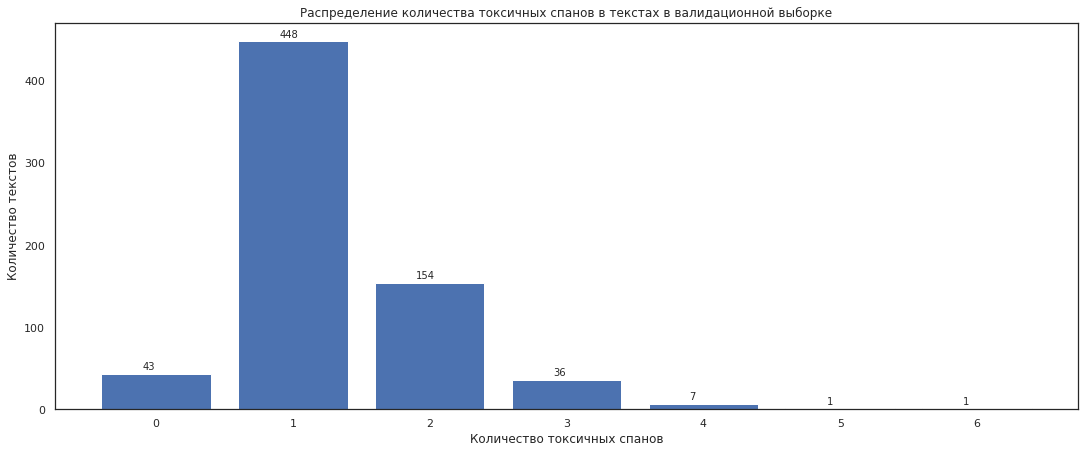

In [24]:
labels, counts = np.unique(num_val_toxic, return_counts=True)
plt.figure(figsize=(15,6))
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
for label, count in zip(labels, counts):
    plt.text(x=label - 0.1, y = count + 5, s = count, fontdict=dict(fontsize=10))
plt.tight_layout()
plt.xlabel('Количество токсичных спанов')
plt.ylabel('Количество текстов')
plt.title(f'Распределение количества токсичных спанов в текстах в {title} выборке')
plt.savefig(f'Распределение токсичных спанов в {title} выборке.png')
plt.show()

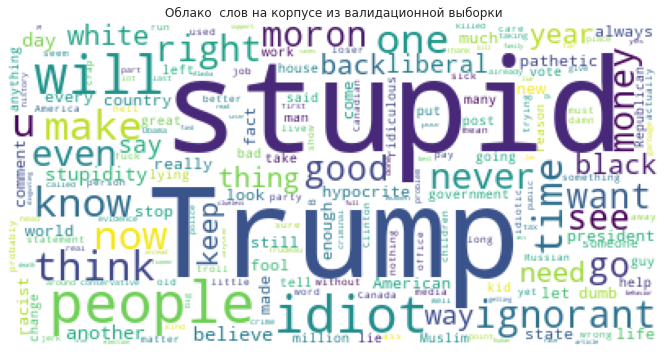

In [25]:
plot_word_cloud(val_df_corpus, title)

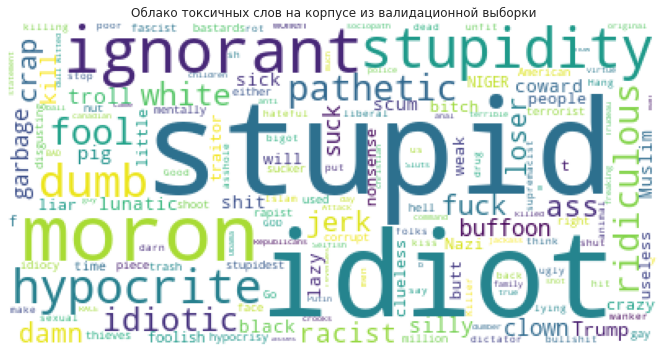

In [26]:
plot_word_cloud(val_toxic_words, title, toxic)

### Подсчет метрик

In [27]:
def jaccard_score(pred, true): 
    pred_tokens = set(pred.lower().split())
    true_tokens = set(true.lower().split())
    if (len(pred_tokens)==0) & (len(true_tokens)==0): 
        return 0.5
    inter_tokens = pred_tokens.intersection(true_tokens)
    return float(len(inter_tokens)) / (len(pred_tokens) + len(true_tokens) - len(inter_tokens))


def f1_score(pred, true):
    pred_tokens = pred.lower().split()
    true_tokens = true.lower().split()

    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens) 

    common_tokens = set(pred_tokens) & set(true_tokens)

    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(true_tokens)

    return 2 * (prec * rec) / (prec + rec)

In [28]:
from os import walk
import os
import pandas as pd
import numpy as np

files = []
path = '../input/toxic-britney/ВКР Results/Impossible/MRC/NO FINE-TUNED/Base'
for (dirpath, dirnames, filenames) in walk(path):
    files.extend(filenames)

In [29]:
path = '../input/toxic-britney/ВКР Results/'

imp_mrc_no_squad_base = []

tokenizer_symbols = {'BERT': ['[SEP]', '[PAD]' ], 'ALBERT': ['[SEP]', '[PAD]'], 
                     'SpanBERT': ['[SEP]', '[PAD]'], 'XLM-RoBERTa': ['nan', '<pad>', '</s>'], 
                     'RoBERTa': ['nan', '<pad>', '</s>'], 
                     'XXLargeALBERT': ['[SEP]', '[PAD]'], 'XLargeALBERT': ['[SEP]', '[PAD]']}

In [30]:
def get_result(path):
    results = {}
    approach = path.split('/')[-3]
    method = path.split('/')[-2]
    for r, d, f in os.walk(path):
        
        for file in f:
            
            #print(os.path.join(r, file))
            model_name = r.split('/')[-1]
            df_name = file.split('_')[0]
            
            #print(model_name, df_name)
            
            temp_df = pd.read_csv(os.path.join(r, file))
            temp_df['predictions'] = temp_df['predictions'].astype(str)
            
            before = temp_df.f1_scores.mean()

            for token in tokenizer_symbols[model_name]:
                #print(model_name, token, len(temp_df[temp_df['predictions'] == token]))
                temp_df['new_predictions'] = temp_df.apply(lambda x: x['predictions'].replace(token, 'impossible')\
                             if len(x['predictions'].split()) == 1 else x['predictions'], axis = 1)

            temp_df['new_f1'] = temp_df.apply(lambda x: f1_score(str(x['new_predictions']), str(x['true_answers'])), axis = 1)

            temp = temp_df.groupby('train_contexts').agg({'new_predictions': lambda x: ' '.join(x), \
                                                          'true_answers': lambda x: ' '.join(x)}).reset_index()

            f1_scores = temp.apply(lambda x: f1_score(x['new_predictions'], x['true_answers']), axis = 1)



            temp_df.name = model_name + ' ' + df_name

            if bool(results.get(model_name)):
                results[model_name][df_name] = np.round(f1_scores.mean(), 3) #[before, temp_df.f1_scores.mean(), f1_scores.mean()] #

            else:
                results[model_name] = {df_name: np.round(f1_scores.mean(), 3)}#[before, temp_df.f1_scores.mean(), f1_scores.mean()]} #

    df = pd.DataFrame(results).T
    df.name = approach + ' ' + method
    
    
    return df

def get_ner_result(path):
    results = {}
    approach = path.split('/')[-3]
    method = path.split('/')[-2]
    for r, d, f in os.walk(path):
        
        for file in f:
            #print(os.path.join(r, file))
            model_name = r.split('/')[-1]
            df_name = file.split('_')[0]
            
            temp_df = pd.read_csv(os.path.join(r, file))
            temp_df['predictions'] = temp_df['predictions'].astype(str)


            if bool(results.get(model_name)):
                results[model_name][df_name] = np.round(temp_df.f1_scores.mean(), 3) #[before, temp_df.f1_scores.mean(), f1_scores.mean()] #

            else:
                results[model_name] = {df_name: np.round(temp_df.f1_scores.mean(), 3)}#[before, temp_df.f1_scores.mean(), f1_scores.mean()]} #

    df = pd.DataFrame(results).T
    df.name = approach + ' ' + method
    return df

Вытягиваем данные по MRC подходу

In [31]:
imp_mrc_no_base = '../input/toxic-britney/Thesis Results/Impossible/MRC/NO FINE-TUNED/Base'
imp_mrc_no_large = '../input/toxic-britney/Thesis Results/Impossible/MRC/NO FINE-TUNED/Large'

imp_mrc_squad_base = '../input/toxic-britney/Thesis Results/Impossible/MRC/SQUAD/BASE'
imp_mrc_squad_large = '../input/toxic-britney/Thesis Results/Impossible/MRC/SQUAD/LARGE'

imp_mrc_squad_gq_base = '../input/toxic-britney/Thesis Results/Impossible/MRC/SQUAD + QG/BASE'
imp_mrc_squad_gq_large = '../input/toxic-britney/Thesis Results/Impossible/MRC/SQUAD + QG/LARGE'

imp_mrc_no_base_df = get_result(imp_mrc_no_base)
imp_mrc_no_large_df = get_result(imp_mrc_no_large)

imp_mrc_squad_base_df = get_result(imp_mrc_squad_base)
imp_mrc_squad_large_df = get_result(imp_mrc_squad_large)


imp_mrc_squad_gq_base_df = get_result(imp_mrc_squad_gq_base)
imp_mrc_squad_gq_large_df = get_result(imp_mrc_squad_gq_large)

Вытягиваем данные по MRC + NER подходу

In [32]:
imp_mrc_ner_base = '../input/toxic-britney/Thesis Results/Impossible/MRC+NER/NO GQ/BASE'
imp_mrc_ner_large = '../input/toxic-britney/Thesis Results/Impossible/MRC+NER/NO GQ/LARGE'          

imp_mrc_ner_qg_base = '../input/toxic-britney/Thesis Results/Impossible/MRC+NER/QG/BASE'
imp_mrc_ner_qg_large = '../input/toxic-britney/Thesis Results/Impossible/MRC+NER/QG/LARGE'


imp_mrc_ner_base_df = get_ner_result(imp_mrc_ner_base)
imp_mrc_ner_large_df = get_ner_result(imp_mrc_ner_large)

imp_mrc_ner_qg_base_df = get_ner_result(imp_mrc_ner_qg_base)
imp_mrc_ner_qg_large_df = get_ner_result(imp_mrc_ner_qg_large)

Вытягиваем данные по no impossible questions:

In [33]:
no_imp_large = '../input/toxic-britney/ВКР Results/Not impossible/LARGE'
no_imp_base = '../input/toxic-britney/ВКР Results/Not impossible/BASE'

no_imp_large_df = get_result(no_imp_large)
no_imp_base_df = get_result(no_imp_base)

Посмотрим на все результаты:

In [34]:
base_models = [imp_mrc_no_base_df, imp_mrc_squad_base_df,  imp_mrc_squad_gq_base_df, imp_mrc_ner_base_df, imp_mrc_ner_qg_base_df]
large_models = [imp_mrc_no_large_df, imp_mrc_squad_large_df, imp_mrc_squad_gq_large_df, imp_mrc_ner_large_df, imp_mrc_ner_qg_large_df]

In [35]:
pd.concat(base_models, axis = 1)

,valid,train,test,valid,train,test,valid,train,test,VAL,TRAIN,TEST,val,train,TEST
BERT,0.582,0.489,0.612,0.576,0.471,0.617,0.581,0.480,0.610,0.601,0.652,0.613,0.621,0.763,0.641
ALBERT,0.662,0.546,0.682,0.637,0.515,0.659,0.660,0.534,0.657,0.587,0.640,0.624,0.583,0.731,0.593
SpanBERT,0.571,0.483,0.624,0.581,0.477,0.620,0.578,0.464,0.607,0.631,0.652,0.631,0.628,0.746,0.644
XLM-RoBERTa,0.675,0.569,0.683,0.632,0.537,0.686,0.635,0.515,0.688,0.544,0.533,0.566,0.643,0.715,0.658
RoBERTa,0.465,0.365,0.475,0.445,0.347,0.492,0.515,0.400,0.542,0.586,0.577,0.622,0.653,0.756,0.647


In [36]:
pd.concat(large_models, axis = 1)

,valid,train,test,valid,train,test,valid,train,test,VAL,TRAIN,TEST,val,train,TEST
XXLargeALBERT,0.661,0.584,0.679,0.668,0.548,0.685,0.617,0.524,0.618,0.559,0.713,0.603,0.611,0.835,0.599
BERT,0.582,0.486,0.605,0.578,0.490,0.602,0.566,0.496,0.606,0.629,0.848,0.634,0.641,0.706,0.652
ALBERT,0.663,0.536,0.674,0.666,0.540,0.681,0.639,0.505,0.649,0.580,0.564,0.596,0.614,0.680,0.625
SpanBERT,0.565,0.509,0.601,0.572,0.492,0.595,0.567,0.469,0.603,0.628,0.715,0.635,0.647,0.787,0.636
XLM-RoBERTa,0.680,0.578,0.683,0.650,0.570,0.598,0.657,0.547,0.677,0.624,0.670,0.632,0.648,0.792,0.647
RoBERTa,0.433,0.360,0.474,0.448,0.365,0.473,0.454,0.372,0.416,0.643,0.649,0.638,0.666,0.696,0.654
XLargeALBERT,0.569,0.439,0.593,0.573,0.452,0.666,0.580,0.463,0.613,0.559,0.558,0.591,0.636,0.645,0.607


In [37]:
# imp_mrc_squad_base_df = imp_mrc_squad_base_df[['train', 'valid', 'test']]
# imp_mrc_squad_base_df.columns = ['squad_train', 'squad_valid', 'squad_test']

In [38]:
def highlight_max(s):
    '''
    highlight the maximum in a Series bold font.
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [39]:
def train_val_test_datasets(models):
    names = []
    train, val, test = [], [], []
    for df in models:
        if 'train' in df.columns:
            train.append(df['train'])
        else:
            train.append(df['TRAIN'])

        if 'valid' in df.columns:
            val.append(df['valid'])
        elif 'VAL' in df.columns:
            val.append(df['VAL'])
        else:
            val.append(df['val'])

        if 'test' in df.columns:
            test.append(df['test'])
        else:
            test.append(df['TEST'])
            
        names.append(df.name)
    
    train = pd.concat(train, axis = 1)
    val = pd.concat(val, axis = 1)
    test = pd.concat(test, axis = 1)
    
    for df in [train, val, test]:
        df.columns = names
        df['Усредненные результаты по моделям'] = df.mean(axis = 1)
        df.loc["Усредненные результаты по подходам"] = df.mean(axis = 0)
        
        
    return train, val, test

In [40]:
train_base, val_base, test_base = train_val_test_datasets(base_models)

In [41]:
train_base

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
BERT,0.4890,0.4710,0.4800,0.6520,0.7630,0.57100
ALBERT,0.5460,0.5150,0.5340,0.6400,0.7310,0.59320
SpanBERT,0.4830,0.4770,0.4640,0.6520,0.7460,0.56440
XLM-RoBERTa,0.5690,0.5370,0.5150,0.5330,0.7150,0.57380
RoBERTa,0.3650,0.3470,0.4000,0.5770,0.7560,0.48900
Усредненные результаты по подходам,0.4904,0.4694,0.4786,0.6108,0.7422,0.55828


In [42]:
mean = train_base.mean(axis = 0)
mean.name = 'Среднее по подходам'

train_base = train_base.append(mean)

In [43]:
train_base

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
BERT,0.4890,0.4710,0.4800,0.6520,0.7630,0.57100
ALBERT,0.5460,0.5150,0.5340,0.6400,0.7310,0.59320
SpanBERT,0.4830,0.4770,0.4640,0.6520,0.7460,0.56440
XLM-RoBERTa,0.5690,0.5370,0.5150,0.5330,0.7150,0.57380
RoBERTa,0.3650,0.3470,0.4000,0.5770,0.7560,0.48900
Усредненные результаты по подходам,0.4904,0.4694,0.4786,0.6108,0.7422,0.55828
Среднее по подходам,0.4904,0.4694,0.4786,0.6108,0.7422,0.55828


In [44]:
train_base.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
BERT,0.489000,0.471000,0.480000,0.652000,0.763000,0.571000
ALBERT,0.546000,0.515000,0.534000,0.640000,0.731000,0.593200
SpanBERT,0.483000,0.477000,0.464000,0.652000,0.746000,0.564400
XLM-RoBERTa,0.569000,0.537000,0.515000,0.533000,0.715000,0.573800
RoBERTa,0.365000,0.347000,0.400000,0.577000,0.756000,0.489000
Усредненные результаты по подходам,0.490400,0.469400,0.478600,0.610800,0.742200,0.558280
Среднее по подходам,0.490400,0.469400,0.478600,0.610800,0.742200,0.558280


In [45]:
val_base.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
BERT,0.582000,0.576000,0.581000,0.601000,0.621000,0.592200
ALBERT,0.662000,0.637000,0.660000,0.587000,0.583000,0.625800
SpanBERT,0.571000,0.581000,0.578000,0.631000,0.628000,0.597800
XLM-RoBERTa,0.675000,0.632000,0.635000,0.544000,0.643000,0.625800
RoBERTa,0.465000,0.445000,0.515000,0.586000,0.653000,0.532800
Усредненные результаты по подходам,0.591000,0.574200,0.593800,0.589800,0.625600,0.594880


In [46]:
test_base.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
BERT,0.612000,0.617000,0.610000,0.613000,0.641000,0.618600
ALBERT,0.682000,0.659000,0.657000,0.624000,0.593000,0.643000
SpanBERT,0.624000,0.620000,0.607000,0.631000,0.644000,0.625200
XLM-RoBERTa,0.683000,0.686000,0.688000,0.566000,0.658000,0.656200
RoBERTa,0.475000,0.492000,0.542000,0.622000,0.647000,0.555600
Усредненные результаты по подходам,0.615200,0.614800,0.620800,0.611200,0.636600,0.619720


In [47]:
train_large, val_large, test_large = train_val_test_datasets(large_models)

In [48]:
train_large.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
XXLargeALBERT,0.584000,0.548000,0.524000,0.713000,0.835000,0.640800
BERT,0.486000,0.490000,0.496000,0.848000,0.706000,0.605200
ALBERT,0.536000,0.540000,0.505000,0.564000,0.680000,0.565000
SpanBERT,0.509000,0.492000,0.469000,0.715000,0.787000,0.594400
XLM-RoBERTa,0.578000,0.570000,0.547000,0.670000,0.792000,0.631400
RoBERTa,0.360000,0.365000,0.372000,0.649000,0.696000,0.488400
XLargeALBERT,0.439000,0.452000,0.463000,0.558000,0.645000,0.511400
Усредненные результаты по подходам,0.498857,0.493857,0.482286,0.673857,0.734429,0.576657


In [49]:
val_large.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
XXLargeALBERT,0.661000,0.668000,0.617000,0.559000,0.611000,0.623200
BERT,0.582000,0.578000,0.566000,0.629000,0.641000,0.599200
ALBERT,0.663000,0.666000,0.639000,0.580000,0.614000,0.632400
SpanBERT,0.565000,0.572000,0.567000,0.628000,0.647000,0.595800
XLM-RoBERTa,0.680000,0.650000,0.657000,0.624000,0.648000,0.651800
RoBERTa,0.433000,0.448000,0.454000,0.643000,0.666000,0.528800
XLargeALBERT,0.569000,0.573000,0.580000,0.559000,0.636000,0.583400
Усредненные результаты по подходам,0.593286,0.593571,0.582857,0.603143,0.637571,0.602086


In [50]:
test_large.style.apply(highlight_max)

,MRC NO FINE-TUNED,MRC SQUAD,MRC SQUAD + QG,MRC+NER NO GQ,MRC+NER QG,Усредненные результаты по моделям
XXLargeALBERT,0.679000,0.685000,0.618000,0.603000,0.599000,0.636800
BERT,0.605000,0.602000,0.606000,0.634000,0.652000,0.619800
ALBERT,0.674000,0.681000,0.649000,0.596000,0.625000,0.645000
SpanBERT,0.601000,0.595000,0.603000,0.635000,0.636000,0.614000
XLM-RoBERTa,0.683000,0.598000,0.677000,0.632000,0.647000,0.647400
RoBERTa,0.474000,0.473000,0.416000,0.638000,0.654000,0.531000
XLargeALBERT,0.593000,0.666000,0.613000,0.591000,0.607000,0.614000
Усредненные результаты по подходам,0.615571,0.614286,0.597429,0.618429,0.631429,0.615429


In [51]:
train_base.to_csv('base_train.csv')
val_base.to_csv('base_val.csv')
test_base.to_csv('base_test.csv')


train_large.to_csv('large_train.csv')
val_large.to_csv('large_val.csv')
test_large.to_csv('large_test.csv')